# Image Denoising with Autoencoders

In [1]:
import numpy as np

from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.utils import to_categorical

%matplotlib inline

### Data Preprocessing

Load the data and reshape

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float')/255.
x_test = x_test.astype('float')/255.

x_train = np.reshape(x_train, (60000, 784))
x_test = np.reshape(x_test, (10000, 784))

### Adding Noise


In [3]:
x_train_noisy = x_train + np.random.rand(60000, 784) * 0.9
x_test_noisy = x_test + np.random.rand(10000, 784) * 0.9

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

#### Plot to view

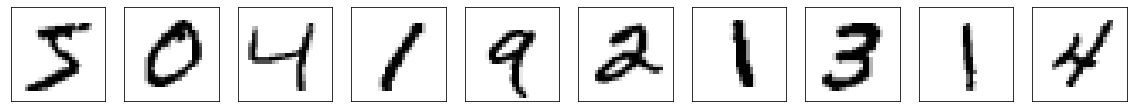

In [7]:
def plot(x, p, labels = False):
    plt.figure(figsize=(20,2))
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.imshow(x[i].reshape(28,28), cmap='binary')
        plt.xticks([])
        plt.yticks([])
        if labels:
            plt.xlabel(np.argmax(p[i]))
    plt.show()
    return
plot(x_train, None)

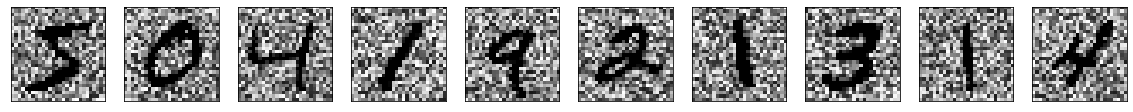

In [8]:
plot(x_train_noisy, None)

### Building and Training a Classifier

In [9]:
classifier = Sequential([
    Dense(256, activation='relu', input_shape=(784,)),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])

classifier.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
classifier.fit(x_train, y_train, epochs=3, batch_size=512)

Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 1s 11us/sample - loss: 0.4233 - accuracy: 0.8849
Epoch 2/3
60000/60000 [==============================] - 1s 8us/sample - loss: 0.1537 - accuracy: 0.9554
Epoch 3/3
60000/60000 [==============================] - 0s 8us/sample - loss: 0.1040 - accuracy: 0.9695


In [10]:
loss, acc = classifier.evaluate(x_test, y_test)
print(acc)

10000/10000 [==============================] - 0s 28us/sample - loss: 0.0978 - accuracy: 0.9696
0.9696


In [11]:
#loss, acc = classifier.evaluate(x_test_noisy, y_test)
#print(acc)

### Building the Autoencoder

In [12]:
input_image = Input(shape=(784,))
encoded = Dense(64, activation='relu')(input_image)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_image, decoded)
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

### Training the Autoencoder

In [13]:
autoencoder.fit(
    x_train_noisy, x_train,
    epochs=100, batch_size=512,
    validation_split=0.2, verbose=False,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5),
        LambdaCallback(on_epoch_end=lambda e,l: print('{:.3f}'.format(l['val_loss']), end=' _ '))
    ]
)

print(' _ ')
print('Training is complete!')

0.254 _ 0.218 _ 0.193 _ 0.179 _ 0.167 _ 0.158 _ 0.150 _ 0.144 _ 0.139 _ 0.135 _ 0.131 _ 0.128 _ 0.126 _ 0.123 _ 0.121 _ 0.119 _ 0.118 _ 0.116 _ 0.115 _ 0.114 _ 0.113 _ 0.112 _ 0.111 _ 0.111 _ 0.110 _ 0.109 _ 0.109 _ 0.109 _ 0.108 _ 0.108 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.106 _ 0.106 _ 0.106 _ 0.106 _ 0.106 _ 0.106 _ 0.106 _ 0.106 _ 0.106 _ 0.106 _ 0.106 _ 0.106 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _  _ 
Training is complete!


### Denoised Images

In [14]:
preds = autoencoder.predict(x_test_noisy)

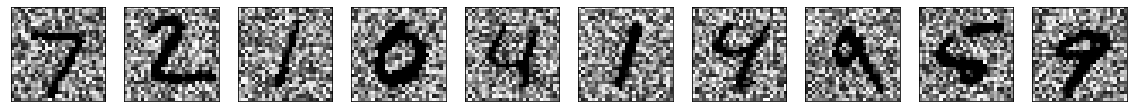

In [15]:
plot(x_test_noisy, None)

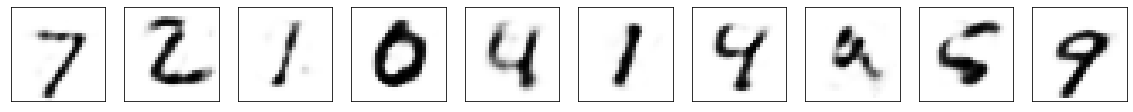

In [16]:
plot(preds, None)

In [17]:
loss, acc = classifier.evaluate(preds, y_test)
print(acc)

10000/10000 [==============================] - 0s 27us/sample - loss: 0.1629 - accuracy: 0.9497
0.9497


### Composite Model


In [18]:
noisy_image = Input(shape=(784,))
x = autoencoder(noisy_image)
y = classifier(x)

denoise_and_classify = Model(noisy_image, y)

In [19]:
p = denoise_and_classify.predict(x_test_noisy)

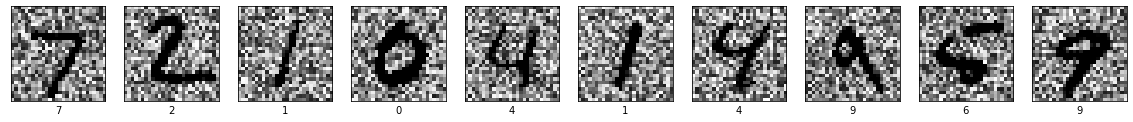

In [20]:
plot(x_test_noisy, p, True)

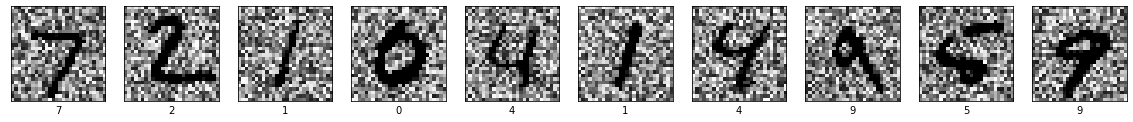

In [21]:
plot(x_test_noisy, to_categorical(y_test), True)